In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def float_to_b16(x):
    integer_rep = round(x * 2**15)
    
    if integer_rep < -32768: integer_rep = -32768
    elif integer_rep > 32767: integer_rep = 32767
    return np.binary_repr(integer_rep, 16)

def b16_to_float(x):
    integer_rep = int(x, 2)
    if integer_rep >= 2**15:
        integer_rep = integer_rep - 2**16
    return integer_rep / 2**15

In [2]:
class CosineWaveform:
    def __init__(self, freq, amp, phase):
        self.freq = freq
        self.amp = amp
        self.phase = phase
    def sample(self, Fs, period, timeErrorLevel = 0):
        #Added a time error level to simulate imperfect clock
        sampleTime = 1 / Fs
        timeSTD = timeErrorLevel * sampleTime
        timeErrorArray = np.array([np.random.normal(loc = 0, scale = timeSTD**2)])
        
        timeArray = np.arange(0, period, 1/Fs)
        return self.amp * np.cos(2 * np.pi * self.freq * (timeArray + timeErrorArray) + self.phase)
    
class Noise:
    def __init__(self, mean, sigma):
        self.mean = mean
        self.sigma = sigma
    def sample(self, Fs, period, timeErrorLevel = 0):
        timeArray = np.arange(0, period, 1/Fs)
        return np.array([np.random.normal(loc = self.mean, scale = self.sigma, size = None) for time in timeArray])
    
class Signal:
    def __init__(self, components):
        self.components = components
        
    def sample(self, Fs, period, timeErrorLevel = 0, quantize = False, UPPER_LIMIT = 1, LOWER_LIMIT = -1):
        waveformArray = np.array([waveform.sample(Fs, period, timeErrorLevel) for waveform in self.components])
        temp = np.zeros(waveformArray.shape[1])
        
        for waveform in waveformArray:
            temp += waveform
        if quantize:
            temp = self.Quantize12Bit(temp, Fs, period, UPPER_LIMIT, LOWER_LIMIT)
        return temp
    
    def Quantize12Bit(self, signal, Fs, period, UPPER_LIMIT, LOWER_LIMIT):
        binRange = UPPER_LIMIT - LOWER_LIMIT
        clippedSignal = np.clip(signal, LOWER_LIMIT, UPPER_LIMIT)
        binWidth = binRange / (2**12 - 1)
        quantized = np.round((clippedSignal - LOWER_LIMIT) / binWidth) * binWidth + LOWER_LIMIT
        return quantized
    
    @staticmethod
    def downSample(Fs, period, signal):
        sampleRatio = len(signal) / (Fs * period)
        indexArray = np.arange(0, len(signal), int(sampleRatio))
        return signal[indexArray]
    

Text(0, 0.5, 'Amplitude')

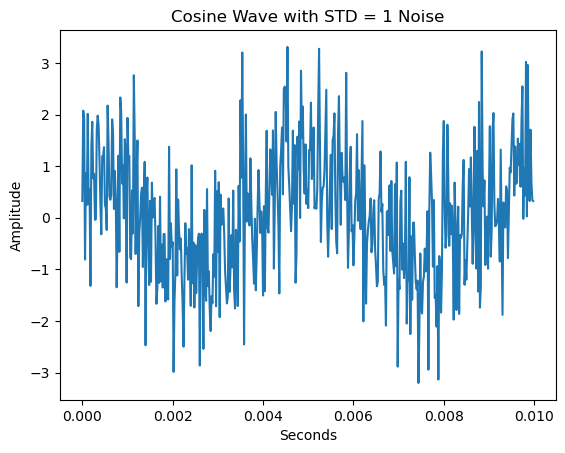

In [3]:
signal = Signal(np.array([
    CosineWaveform(freq = 200, amp = 1, phase = 0),
    Noise(mean = 0, sigma = 1)
]))

Fs = 50000
period = 5

sample = signal.sample(Fs, period)
xAxis = np.arange(0, 2 / 200, 1/ Fs)

plt.plot(xAxis, sample[0:500])
plt.title("Cosine Wave with STD = 1 Noise")
plt.xlabel("Seconds")
plt.ylabel("Amplitude")

In [6]:
parsed_sample = np.array(list(map(float_to_b16, sample)))

def create_FIR_files(signal_sample, sample_file_name):
    now = datetime.now()
    signal_sample.tofile(sample_file_name, sep ='\n', format='%s')
    
def unpack_signal_data(file_object):
    with file_object as f:
        lines = f.read().splitlines()
        
    return np.array([line for line in lines])

In [7]:
f_low = 300
f_high = 3400
taps = 401

#create_FIR_files(parsed_sample, Fs = Fs, f_low = f_low , f_high = f_high , taps = taps)

N = 401
Fs = 48000 #48kHz for audio

w_low = 2 * np.pi * f_low / Fs
w_high = 2 * np.pi * f_high / Fs

n = np.arange(N) - (N-1)/2.0
h = (w_high/np.pi) * np.sinc((w_high / np.pi) *n) - (w_low/np.pi) * np.sinc((w_low / np.pi) *n)
hWindow = h * np.hanning(N)

mapped16bit_weighting = np.array(list(map(float_to_b16, hWindow)))

create_FIR_files(mapped16bit_weighting, "weighting.mem")